## Changing the concentration of the inducer

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy.optimize import curve_fit

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/fig10/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1.1 Calculating average mutual information as a function of inducer concentration

Firstly, we define the function `simrep_pbound_with_inducer`, which calculates $p_{\mathrm{bound}}$ when the repressor in the simple repression motif is made inducible. In addition, we define the helper function `get_pactive` which calculates the proportion of repressors that are active.

In [6]:
def get_pactive(c, KA, KI, eAI):
    """
    Calculate the probability that the repressor is in an active state

    Parameters:
    ----------
    c : float
        Concentration of the inducer.
    KA : float
        Dissociation constant of inducer binding to the active repressor.
    KI : float
        Dissociation constant of inducer binding to the inactive repressor.
    eAI : float
        Free energy difference between the active repressor state and the inactive repressor state.

    Returns:
    -------
    float
        The probability that the repressor is in an active state.
    """
    z = np.zeros(4)
    z[0] = 1
    z[1] = c / KA
    z[2] = np.exp(-eAI)
    z[3] = c / KI
    return (z[0] + z[1])**2 / ((z[0] + z[1])**2 + z[2] * (1 + z[3])**2)


def simrep_pbound_with_inducer(p_seq, r_seq, n_NS, n_p, n_r,
                               p_emat, r_emat, ep_wt, era_wt, eri_wt,
                               c, KA, KI, eAI):
    """
    Calculate the probability of RNAP being bound in the presence of an inducer.

    Parameters:
    ----------
    p_seq : str
        Sequence of the RNAP binding site.
    r_seq : str
        Sequence of the repressor binding site.
    n_NS : float
        Scaling factor for non-specific binding.
    n_p : int
        Number of RNAP.
    n_r : int
        Number of repressors.
    p_emat : array-like
        Energy matrix for RNAP.
    r_emat : array-like
        Energy matrix for repressor.
    ep_wt : float
        Wild-type binding energy for RNAP.
    era_wt : float
        Wild-type binding energy for the active repressor.
    eri_wt : float
        Wild-type binding energy for the inactive repressor.
    c : float
        Concentration of the inducer.
    KA : float
        Dissociation constant of inducer binding to the active repressor.
    KI : float
        Dissociation constant of inducer binding to the inactive repressor.
    eAI : float
        Free energy difference between the active repressor state and the inactive repressor state.

    Returns:
    -------
    float
        The probability of RNAP being bound.
    """
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_ra = tregs.simulate.get_weight(r_seq, r_emat, e_wt=era_wt)
    w_ri = tregs.simulate.get_weight(r_seq, r_emat, e_wt=eri_wt)
    pactive = get_pactive(c, KA, KI, eAI)

    z = np.zeros(4)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = pactive * n_r / n_NS * w_ra
    z[3] = (1 - pactive) * n_r / n_NS * w_ri

    return z[1] / np.sum(z)

For each inducer concentration, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand`.

In [7]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We define the usual parameters needed for a simple repression thermodynamic model and the range of inducer concentrations. For each inducer concentration, we build synthetic datasets for each of the 20 pre-generated synthetic dataset and we keep track of the average mutual information at the repressor binding site.

In [8]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
era_wt = -15
eri_wt = -1
KA = 139 * 10**(-6)
KI = 0.53 * 10**(-6)
eAI = 4.5

signal = []
inducer_conc = []
for i in np.arange(-7, -2, 0.2):
    c = 10**i
    inducer_conc.append(c)

    tmp = []
    for i in range(20):
        df = tregs.simulate.sim(promoter, simrep_pbound_with_inducer, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, era_wt, eri_wt, c, KA, KI, eAI])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        tmp.append(np.mean(footprint[(2+115):(17+116)]))
    signal.append(np.mean(tmp))

The curve is sigmoidal shaped, and we fit a sigmoidal curve to it. Before doing so, we also normalize the inducer concentration by dividing it by the values of $K_A$.

In [9]:
def sigmoid(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

p0 = [-max(signal), min(signal), 1, 1] # mandatory initial guess

norm_inducer_conc = np.asarray(inducer_conc) / KA

popt, pcov = curve_fit(sigmoid, norm_inducer_conc, signal, p0, maxfev=10000)

Finally, we plot the average mutual information at the repressor binding site against the normalized inducer concentration.

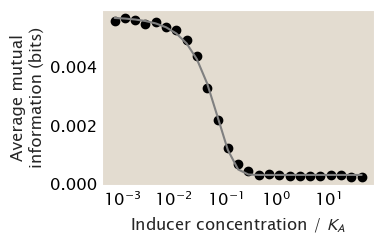

In [10]:
fig, ax = plt.subplots(figsize=(4, 2.6))
ax.scatter(norm_inducer_conc, signal, color='k')
ax.plot(norm_inducer_conc, sigmoid(norm_inducer_conc, *popt), color='grey')
ax.set_xscale('log')
ax.set_xticks([0.001, 0.01, 0.1, 1, 10])
ax.set_xlabel('Inducer concentration / ' + r'$K_A$')
ax.set_ylabel('Average mutual\ninformation (bits)')
plt.tight_layout()
plt.savefig('../plots/fig10/inducer.pdf', bbox_inches='tight')

### 1.2 Example information footprint at high and low inducer concentrations

First, we simulate an information footprint at the inducer concentration $10^{-6}\, M$.

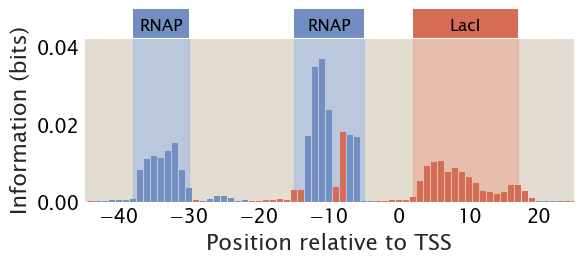

In [11]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
era_wt = -15
eri_wt = -1
c = 10**(-6)
KA = 139 * 10**(-6)
KI = 0.53 * 10**(-6)
eAI = 4.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_inducer, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, era_wt, eri_wt, c, KA, KI, eAI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig10/inducer_fp1.pdf')

We also simulate an information footprint at the inducer concentration $10^{-3}\, M$.

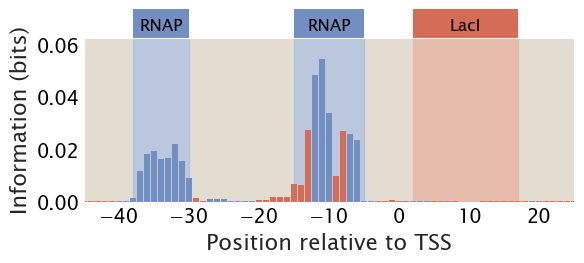

In [12]:
n_NS = len(genome)
n_p = 5000
n_r1 = 10
ep_wt = -5
era_wt = -15
eri_wt = -1
c = 10**(-3)
KA = 139 * 10**(-6)
KI = 0.53 * 10**(-6)
eAI = 4.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_inducer, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, era_wt, eri_wt, c, KA, KI, eAI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig10/inducer_fp2.pdf')